# Create your own Deep Learning framework using Numpy

https://quantdare.com/create-your-own-deep-learning-framework-using-numpy/

1. Neural networks in a nutshell
2. Gradient descent and backpropagation
3. Putting things together
4. Give me the code!

Here it is! A neural network will be created using the Model class.

In [1]:
class Model:
    def __init__(self):
        self.layers = []
        self.loss = []
     
    def add(self, layer):
        self.layers.append(layer)
     
    def predict(self, X):
        # Forward pass
        for i, _ in enumerate(self.layers):
            forward = self.layers[i].forward(X)
            X = forward
             
        return forward
     
    def train(
        self, 
        X_train, 
        Y_train, 
        learning_rate, 
        epochs, 
        verbose=False
    ):
        for epoch in range(epochs):
            loss = self._run_epoch(X_train, Y_train, learning_rate)
             
            if verbose:
                if epoch % 50 == 0:
                    print(f'Epoch: {epoch}. Loss: {loss}')
     
    def _run_epoch(self, X, Y, learning_rate):
        # Forward pass
        for i, _ in enumerate(self.layers):
            forward = self.layers[i].forward(input_val=X)
            X = forward
             
        # Compute loss and first gradient
        bce = BinaryCrossEntropy(forward, Y)
        error = bce.forward()
        gradient = bce.backward()
         
        self.loss.append(error)
         
        # Backpropagation
        for i, _ in reversed(list(enumerate(self.layers))):
            if self.layers[i].type != 'Linear':
                gradient = self.layers[i].backward(gradient)
            else:
                gradient, dW, dB = self.layers[i].backward(gradient)
                self.layers[i].optimize(dW, dB, learning_rate)
                 
        return error

As you can see, the class Model has 3 methods: add, train and predict that allow us to control the network behaviour.

The private method _run_epoch computes only one epoch. It does it by following the next procedure:

- Compute forward pass.
- Calculate error and gradient on the last layer.
- Backpropagates the gradient.

Notice that we don’t actually need the error in backpropagation, just the gradient. We use the error to see how far we are from our objective.

In [2]:
class Layer:
    """Layer abstract class"""
    def __init__(self):
        pass
     
    def __len__(self):
        pass
     
    def __str__(self):
        pass
     
    def forward(self):
        pass
     
    def backward(self):
        pass
     
    def optimize(self):
        pass
 
 
class Linear(Layer):
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.rand(output_dim, input_dim)
        self.biases = np.random.rand(output_dim, 1)
        self.type = 'Linear'
 
    def __str__(self):
        return f"{self.type} Layer"
         
    def forward(self, input_val):
        self._prev_acti = input_val
        return np.matmul(self.weights, input_val) + self.biases
     
    def backward(self, dA):
        dW = np.dot(dA, self._prev_acti.T)
        dB = dA.mean(axis=1, keepdims=True)
         
        delta = np.dot(self.weights.T, dA)
         
        return delta, dW, dB
     
    def optimize(self, dW, dB, rate):
        self.weights = self.weights - rate * dW
        self.biases = self.biases - rate * dB
 
 
class ReLU(Layer):    
    def __init__(self, output_dim):
        self.units = output_dim
        self.type = 'ReLU'
 
    def __str__(self):
        return f"{self.type} Layer"       
         
    def forward(self, input_val):
        self._prev_acti = np.maximum(0, input_val)
        return self._prev_acti
     
    def backward(self, dJ):
        return dJ * np.heaviside(self._prev_acti, 0)
 
 
class Sigmoid(Layer):
    def __init__(self, output_dim):
        self.units = output_dim
        self.type = 'Sigmoid'
 
    def __str__(self):
        return f"{self.type} Layer"       
         
    def forward(self, input_val):
        self._prev_acti = 1 / (1 + np.exp(-input_val))
        return self._prev_acti
     
    def backward(self, dJ):
        sig = self._prev_acti
        return dJ * sig * (1 - sig)

To calculate the error, we have a lot of options. Probably, the most basic one is the Mean Squared Error we saw earlier. I have added another one called Binary Cross-Entropy (the one that is in the code) because we will test our model using the latter in the following sections.

In [3]:
class MeanSquaredError(Layer):
    def __init__(self, predicted, real):
        self.predicted = predicted
        self.real = real
        self.type = 'Mean Squared Error'
     
    def forward(self):
        return np.power(self.predicted - self.real, 2).mean()
 
    def backward(self):
        return 2 * (self.predicted - self.real).mean()
 
 
class BinaryCrossEntropy(Layer):
    def __init__(self, predicted, real):
        self.real = real
        self.predicted = predicted
        self.type = 'Binary Cross-Entropy'
     
    def forward(self):
        n = len(self.real)
        loss = np.nansum(-self.real * np.log(self.predicted) - (1 - self.real) * np.log(1 - self.predicted)) / n
         
        return np.squeeze(loss)
     
    def backward(self):
        n = len(self.real)
        return (-(self.real / self.predicted) + ((1 - self.real) / (1 - self.predicted))) / n


The layers can compute in 2 directions: forward and backward. This is an inherited behaviour from the computational graphs design, and it makes computationally easier to calculate the derivatives. In fact, we could have split the Linear layer into “multiply and “add” classes, as TensorFlow does it.

The weights and biases are initialized using a uniform distribution. There are other ways to initialize these parameters, like kaiming initialization.

The forward pass of a linear layer just computes the formula of a neuron we saw previously. The backward pass is a little trickier to understand: once we compute the gradient on the last layer, we backpropagate it by multiplying the corresponding derivatives of the actual layer with the incoming gradient of the following layer.

In [4]:
def generate_data(samples, shape_type='circles', noise=0.05):
    # We import in the method for the shake of simplicity

    if shape_type is 'moons':
        X, Y = make_moons(n_samples=samples, noise=noise)
    elif shape_type is 'circles':
        X, Y = make_circles(n_samples=samples, noise=noise)
    else:
        raise ValueError(f"The introduced shape {shape_type} is not valid. Please use 'moons' or 'circles' ")
     
    data = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))
     
    return data
 
def plot_generated_data(data):
    ax = data.plot.scatter(x='x', y='y', figsize=(16,12), color=data['label'], 
                 cmap=matplotlib.colors.ListedColormap(['skyblue', 'salmon']), grid=True);
     
    return ax

/Users/caihaocui/opt/miniconda3/envs/py37automl/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:245: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  "'color' and 'colormap' cannot be used simultaneously. Using 'color'"


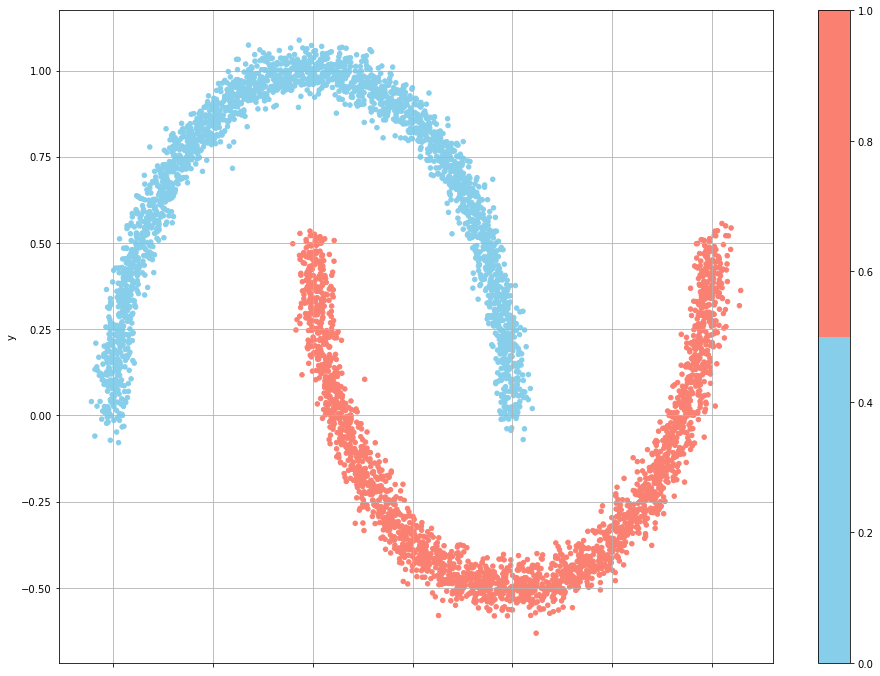

In [5]:
import matplotlib
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.datasets import make_moons, make_circles 
data = generate_data(samples=5000, shape_type='moons', noise=0.04)
plot_generated_data(data);

The creation and addition of layers to the model is very straightforward because it works pretty much the same as in Keras. Below you will find the code to create and train a classification model:

In [6]:
import numpy as np
X = data[['x', 'y']].values
Y = data['label'].T.values

In [7]:
# Create model
model = Model()
model.add(Linear(2, 5))
model.add(ReLU(5))
 
model.add(Linear(5,5))
model.add(ReLU(5))
 
model.add(Linear(5,1))
model.add(Sigmoid(1))

# Train model
model.train(X_train = X.T, 
            Y_train = Y, 
            learning_rate = 0.05, 
            epochs=9000,
            verbose=False)

After training, we can plot the loss of the model:

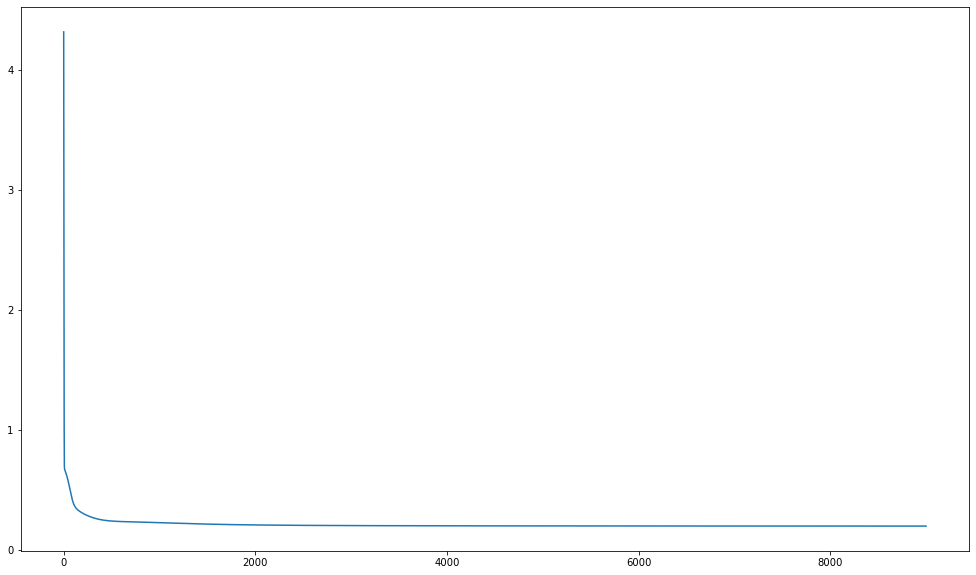

In [8]:
plt.figure(figsize=(17,10))
plt.plot(model.loss)

The loss curve is not ideal, but is good enough for our purposes.

In [9]:
def plot_decision_boundary(X, y, model, steps=1000, cmap='Paired'):
    cmap = plt.get_cmap(cmap)

    # Define region of interest by data limits
    xmin, xmax = X[:,0].min() - 1, X[:,0].max() + 1
    ymin, ymax = X[:,1].min() - 1, X[:,1].max() + 1
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
#     labels = model.predict(np.c_[xx.ravel(), yy.ravel()])
    XN = np.c_[xx.ravel(), yy.ravel()]
    labels = model.predict(XN.T).T

    # Plot decision boundary in region of interest
    z = labels.reshape(xx.shape)

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=cmap, alpha=0.5)

    # Get predicted labels on training data and plot
    train_labels = model.predict(X.T).T
    ax.scatter(X[:,0], X[:,1], c=train_labels, cmap=cmap, lw=0)

    return fig, ax

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

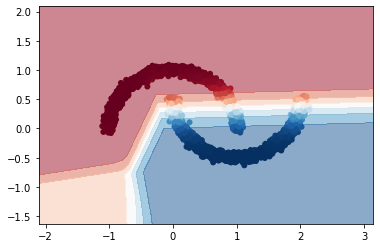

In [10]:
plot_decision_boundary(X, Y, model, cmap='RdBu')

In [11]:
from sklearn.metrics import roc_auc_score
 
# Make predictions
predictions = model.predict(X.T).T
 
# Format the predictions
new_pred = []
 
for p in predictions:
    if p < 0.5:
        new_pred.append(0)
    else:
        new_pred.append(1)
        
# Calculate the score
roc_auc_score(y_true=Y, y_score=new_pred)

0.895

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

In [13]:
# Define our model object
model = Sequential()

# kwarg dict for convenience
layer_kw = dict(activation='sigmoid')

# Add layers to our model
model.add(Dense(units=5, input_shape=(2, ), **layer_kw))
model.add(Dense(units=5, **layer_kw))
model.add(Dense(units=1, **layer_kw))

2021-09-12 09:50:42.078503: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
sgd = SGD(lr=0.001)

/Users/caihaocui/opt/miniconda3/envs/py37automl/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [15]:
model.compile(optimizer=sgd, loss='binary_crossentropy')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 15        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(X , Y , verbose=0,  shuffle=True)

2021-09-12 09:50:42.307384: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

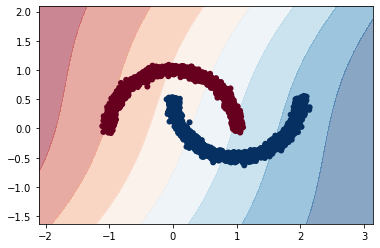

In [18]:
def plot_decision_boundary(X, y, model, steps=1000, cmap='Paired'):
    cmap = plt.get_cmap(cmap)

    # Define region of interest by data limits
    xmin, xmax = X[:,0].min() - 1, X[:,0].max() + 1
    ymin, ymax = X[:,1].min() - 1, X[:,1].max() + 1
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    labels = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Plot decision boundary in region of interest
    z = labels.reshape(xx.shape)

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=cmap, alpha=0.5)

    # Get predicted labels on training data and plot
    train_labels = model.predict(X)
    ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, lw=0)

    return fig, ax


plot_decision_boundary(X, Y, model, cmap='RdBu')